In [16]:
import math
import numpy
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator
from pathlib import Path

import torch
import torch.nn.functional as Fun
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU

In [17]:
from torch_geometric.datasets import QM9
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool

In [18]:
import sys
if sys.platform.startswith(("linux", "darwin")):
    !mamba install -q -y -c pyg pyg

In [19]:
# specify the local data path
HERE = Path("./data")
DATA = HERE 

In [24]:
# load dataset
qm9 = QM9(root=DATA)


In [25]:
len(qm9.data.y)
qm9[10000].y

c:\Users\friha\.conda\envs\NetSci\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


tensor([[ 3.0178e+00,  6.7000e+01, -6.8518e+00, -8.8981e-01,  5.9620e+00,
          1.0346e+03,  3.4614e+00, -1.0442e+04, -1.0441e+04, -1.0441e+04,
         -1.0443e+04,  3.2217e+01, -6.8336e+01, -6.8706e+01, -6.9092e+01,
         -6.3758e+01,  2.4398e+00,  1.8664e+00,  1.1283e+00]])

In [1]:

# Install required libraries
%pip install torch-geometric
%pip install rdkit-pypi
%pip install py3Dmol

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Data object: Data(x=[8, 11], edge_index=[2, 14], edge_attr=[14, 4], y=[1, 19], pos=[8, 3], z=[8], smiles='[H]N([H])C(=O)N([H])[H]', name='gdb_20', idx=[1])

Key components:
Number of nodes (atoms): 8
Node features shape: torch.Size([8, 11]) [nodes x atom features]
Edge indices shape: torch.Size([2, 14]) [2 x edges]
Edge attributes shape: torch.Size([14, 4]) [edges x bond features]
3D positions shape: torch.Size([8, 3]) [nodes x 3D coordinates]
Target properties (19): torch.Size([1, 19])

Node features for first 5 atoms:
Atom 1: N
Properties: {'atomic_number': 7.0, 'charge': 0.0, 'mass': 0.0, 'vdw_radius': 0.0, 'electronegativity': 0.0, 'aromatic': True}

tensor([0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 2.])
Atom 2: C
Properties: {'atomic_number': 6.0, 'charge': 0.0, 'mass': 0.0, 'vdw_radius': 0.0, 'electronegativity': 0.0, 'aromatic': False}

tensor([0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.])
Atom 3: N
Properties: {'atomic_number': 7.0, 'charge': 0.0, 'mass': 0.0, 'vdw_radius': 0.0, '

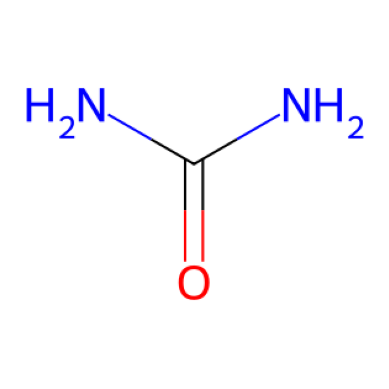

3Dmol.js failed to load for some reason. Please check your browser console for error messages.


First 10 target properties:
0. Dipole moment: 3.4869
1. Isotropic polarizability: 28.0700
2. HOMO energy: -6.7892
3. LUMO energy: 1.5130
4. HOMO-LUMO gap: 8.3022
5. Electronic spatial extent: 244.2308
6. ZPVE: 1.7367
7. U(0K): -6128.5884
8. U(298K): -6128.4688
9. H(298K): -6128.4429
10. G(298K): -6129.3027
11. Heat capacity: 15.2920
12. U0 atomization: -31.0562
13. U atomization: -31.2452
14. H atomization: -31.4251
15. G atomization: -28.9903
16. Rotational A: 11.1475
17. Rotational B: 10.3639
18. Rotational C: 5.4209


In [51]:
# %% [markdown]
# # QM9 Dataset Exploration
# 
# The QM9 dataset contains 133,885 small organic molecules with up to 9 heavy atoms (C, O, N, F). Each molecule has:
# - Quantum chemical properties
# - 3D atomic coordinates
# - Molecular graph structure (nodes = atoms, edges = bonds)


import torch
from torch_geometric.datasets import QM9
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
import py3Dmol
import matplotlib.pyplot as plt

# Load dataset
dataset = QM9(root=DATA)
data = dataset[19]  # Get first molecule

# %% [markdown]
# ### Dataset Overview
# Each entry contains:
# - Node features (atom types)
# - Edge indices (molecular connections)
# - Edge attributes (bond types + distances)
# - 3D coordinates
# - 19 target properties
# - SMILES representation

# %%
# Basic data inspection
print("Data object:", data)
print("\nKey components:")
print(f"Number of nodes (atoms): {data.num_nodes}")
print(f"Node features shape: {data.x.shape} [nodes x atom features]")
print(f"Edge indices shape: {data.edge_index.shape} [2 x edges]")
print(f"Edge attributes shape: {data.edge_attr.shape} [edges x bond features]")
print(f"3D positions shape: {data.pos.shape} [nodes x 3D coordinates]")
print(f"Target properties (19): {data.y.shape}")

# %% [markdown]
# ### Node Features (Atom Types)
# One-hot encoded features for atomic numbers:
# - Index 0: Hydrogen (H)
# - Index 1: Carbon (C)
# - Index 2: Nitrogen (N)
# - Index 3: Oxygen (O)
# - Index 4: Fluorine (F)

# %%
# Correct node feature inspection
atom_types = ['H', 'C', 'N', 'O', 'F']
print("\nNode features for first 5 atoms:")
for i in range(min(5, data.num_nodes)):  # Safer boundary check
    features = data.x[i]
    atom_idx = torch.argmax(features[:5]).item()  # Only consider first 5 dimensions
    atom_props = {
        'atomic_number': features[5].item(),
        'charge': features[6].item(),
        'mass': features[7].item(),
        'vdw_radius': features[8].item(),
        'electronegativity': features[9].item(),
        'aromatic': bool(features[10].item())
    }
    
    print(f"Atom {i+1}: {atom_types[atom_idx]}")
    print(f"Properties: {atom_props}\n")
    print(f"{features}")
# %% [markdown]
# ### Edge Attributes (Bond Information)
# Each edge has:
# - Bond type (1.0=Single, 1.5=Aromatic, 2.0=Double, 3.0=Triple)
# - Bond length (Angstroms)

# %%
# Correct edge attribute inspection
bond_type_map = {1.0: 'Single', 1.5: 'Aromatic', 2.0: 'Double', 3.0: 'Triple'}
print("\nFirst 5 edge attributes:")
for i in range(min(5, data.edge_attr.shape[0])):
    attr = data.edge_attr[i]
    print(f"Edge {i+1}:")
    print(f"  Bond type: {bond_type_map.get(attr[0].item(), 'Unknown')}")
    print(f"  Distance: {attr[1].item():.3f} Å")
    print(f"  Same ring: {bool(attr[2].item())}")
    print(f"  Conjugated: {bool(attr[3].item())}\n")

# %% [markdown]
# ### Molecular Visualization
# 2D structure from SMILES and 3D coordinates visualization

# %%
# 2D structure using SMILES
mol = Chem.MolFromSmiles(data.smiles)
img = Draw.MolToImage(mol, size=(300, 300))
plt.imshow(img)
plt.axis('off')
plt.show()

# %%
# 3D visualization using atomic coordinates
# Corrected 3D visualization with type conversion
def visualize_3d(pos, atom_types):
    viewer = py3Dmol.view(width=400, height=300)
    atom_dict = {
        0: {'symbol': 'H', 'color': 'white', 'radius': 0.3},
        1: {'symbol': 'C', 'color': 'gray', 'radius': 0.6},
        2: {'symbol': 'N', 'color': 'blue', 'radius': 0.6},
        3: {'symbol': 'O', 'color': 'red', 'radius': 0.6},
        4: {'symbol': 'F', 'color': 'green', 'radius': 0.6}
    }
    
    for i, (x, y, z) in enumerate(pos):
        if i >= len(atom_types):
            break
        
        # Convert numpy types to native Python types
        atom_type = int(atom_types[i])  # Convert to native int
        x, y, z = float(x), float(y), float(z)  # Convert to native float
        
        atom_info = atom_dict.get(atom_type, {'color': 'pink', 'radius': 0.5})
        
        # Use explicit type conversion in sphere parameters
        viewer.addSphere({
            'center': {'x': x, 'y': y, 'z': z},
            'radius': float(atom_info['radius']),  # Ensure native float
            'color': str(atom_info['color'])       # Ensure string type
        })
    
    viewer.setStyle({'stick': {'radius': 0.2}})
    viewer.zoomTo()
    return viewer.show()

# Get atom indices with proper type conversion
atom_indices = torch.argmax(data.x[:, :5], dim=1).numpy().astype(int)
visualize_3d(data.pos.numpy(), atom_indices)

# %% [markdown]
# ### Target Properties
# The 19 quantum chemical properties include:
# 0. Dipole moment (μ)
# 1. Isotropic polarizability (α)
# 2. HOMO energy (ε_HOMO)
# 3. LUMO energy (ε_LUMO)
# 4. HOMO-LUMO gap (Δε)
# 5. Electronic spatial extent (⟨R²⟩)
# ...and other thermodynamic properties

# %%
# Display first 10 properties
property_names = [
    'Dipole moment', 'Isotropic polarizability', 'HOMO energy',
    'LUMO energy', 'HOMO-LUMO gap', 'Electronic spatial extent',
    'ZPVE', 'U(0K)', 'U(298K)', 'H(298K)', 'G(298K)', 'Heat capacity',
    'U0 atomization', 'U atomization', 'H atomization', 'G atomization',
    'Rotational A', 'Rotational B', 'Rotational C'
]

print("\nFirst 10 target properties:")
for i, (name, value) in enumerate(zip(property_names[:], data.y[0, :])):
    print(f"{i}. {name}: {value:.4f}")

Data object type: <class 'torch_geometric.data.data.Data'>

Key components:
Number of nodes (atoms): 14
Node features shape: torch.Size([14, 11]) (11 features per atom)
Edge indices shape: torch.Size([2, 26]) (2 x 26 connections)
Edge attributes shape: torch.Size([26, 4]) (4 bond features per edge)
3D positions shape: torch.Size([14, 3]) (XYZ coordinates)
Target properties shape: torch.Size([1, 19]) (19 quantum properties)

Atomic properties for first 5 atoms:
Atom 1:
  Type           : C
  Atomic_number  : 6.0
  Charge         : 0.0
  Mass           : 0.00 amu
  Vdw_radius     : 0.00 Å
  Electronegativity: 0.00
  Aromatic       : Yes
Atom 2:
  Type           : C
  Atomic_number  : 6.0
  Charge         : 0.0
  Mass           : 0.00 amu
  Vdw_radius     : 0.00 Å
  Electronegativity: 0.00
  Aromatic       : Yes
Atom 3:
  Type           : C
  Atomic_number  : 6.0
  Charge         : 0.0
  Mass           : 0.00 amu
  Vdw_radius     : 0.00 Å
  Electronegativity: 0.00
  Aromatic       : Yes
A

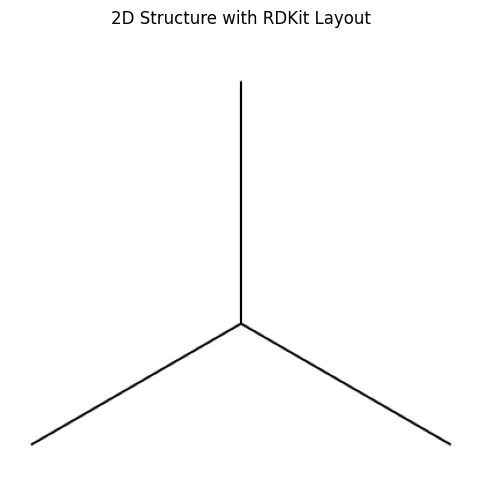

3Dmol.js failed to load for some reason. Please check your browser console for error messages.


Quantum Chemical Properties:
 0. Dipole moment             (μ):   0.0897 Debye
 1. Isotropic polarizability  (α):  45.4600 a.u.
 2. HOMO energy               (ε_HOMO):  -8.6178 eV
 3. LUMO energy               (ε_LUMO):   2.2939 eV
 4. HOMO-LUMO gap             (Δε):  10.9118 eV
 5. Electronic spatial extent (<R²>): 355.0621 a.u.
 6. Zero-point vibrational energy (ZPVE):   3.5687 eV
 7. Internal energy (0K)      (U(0K)): -4308.7148 eV
 8. Internal energy (298K)    (U(298K)): -4308.5586 eV
 9. Enthalpy (298K)           (H(298K)): -4308.5327 eV
10. Free energy (298K)        (G(298K)): -4309.4673 eV
11. Heat capacity             (Cv):  20.2730 cal/(mol·K)
12. Atomization energy (U0)   (U0): -53.1310 eV
13. Atomization energy (U)    (U): -53.5143 eV
14. Atomization enthalpy      (H): -53.8485 eV
15. Atomization free energy   (G): -49.4017 eV
16. Rotational constant A     (A):   7.7517 GHz
17. Rotational constant B     (B):   7.7485 GHz
18. Rotational constant C     (C):   4.4867 GHz


In [53]:
# %% [markdown]
# # QM9 Dataset Exploration (Enhanced)
# 
# The QM9 dataset contains 133,885 small organic molecules with up to 9 heavy atoms (C, O, N, F). Each molecule has:
# - Quantum chemical properties
# - 3D atomic coordinates
# - Molecular graph structure (nodes = atoms, edges = bonds)

# %%
import torch
from torch_geometric.datasets import QM9
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
import py3Dmol
import matplotlib.pyplot as plt

# Load dataset with verification
dataset = QM9(root=DATA)
data = dataset[20]  # Get molecule at index 19

# %% [markdown]
# ### Enhanced Dataset Overview
# Each entry contains:
# - **Node features**: 11 dimensions (atom type + properties)
# - **Edge attributes**: 4 dimensions (bond type + spatial info)
# - **3D coordinates**: DFT-optimized geometries
# - **Target properties**: 19 quantum chemical properties
# - **SMILES representation**: Chemical structure notation

# %%
# Robust data inspection
print("Data object type:", type(data))
print("\nKey components:")
print(f"Number of nodes (atoms): {data.num_nodes}")
print(f"Node features shape: {data.x.shape} (11 features per atom)")
print(f"Edge indices shape: {data.edge_index.shape} (2 x {data.edge_index.shape[1]} connections)")
print(f"Edge attributes shape: {data.edge_attr.shape} (4 bond features per edge)")
print(f"3D positions shape: {data.pos.shape} (XYZ coordinates)")
print(f"Target properties shape: {data.y.shape} (19 quantum properties)")

# %% [markdown]
# ### Enhanced Node Features Analysis
# Full node feature specification:
# 0-4: Atom type (one-hot: H, C, N, O, F)  
# 5: Atomic number  
# 6: Formal charge  
# 7: Atomic mass  
# 8: Van der Waals radius  
# 9: Pauling electronegativity  
# 10: Aromaticity indicator

# %%
# Atomic property analysis
atom_types = ['H', 'C', 'N', 'O', 'F']
print("\nAtomic properties for first 5 atoms:")
for i in range(min(5, data.num_nodes)):
    features = data.x[i]
    atom_idx = torch.argmax(features[:5]).item()
    
    atom_info = {
        'type': atom_types[atom_idx],
        'atomic_number': features[5].item(),
        'charge': features[6].item(),
        'mass': f"{features[7].item():.2f} amu",
        'vdw_radius': f"{features[8].item():.2f} Å",
        'electronegativity': f"{features[9].item():.2f}",
        'aromatic': "Yes" if features[10].item() > 0.5 else "No"
    }
    
    print(f"Atom {i+1}:")
    for k, v in atom_info.items():
        print(f"  {k.capitalize():<15}: {v}")

# %% [markdown]
# ### Enhanced Edge Attribute Analysis
# Edge features include:
# 0: Bond type (1=Single, 2=Double, 3=Triple, 1.5=Aromatic)  
# 1: Bond length (Ångströms)  
# 2: Same ring membership  
# 3: Conjugation status

# %%
# Bond analysis with chemical accuracy
bond_type_map = {
    1.0: 'Single', 
    1.5: 'Aromatic', 
    2.0: 'Double', 
    3.0: 'Triple'
}

print("\nFirst 5 chemical bonds:")
for i in range(min(5, data.edge_attr.shape[0])):
    bond = data.edge_attr[i]
    src = data.edge_index[0, i].item() + 1
    dst = data.edge_index[1, i].item() + 1
    
    print(f"Bond {i+1}: Atom {src} - Atom {dst}")
    print(f"  Type: {bond_type_map.get(bond[0].item(), 'Complex')}")
    print(f"  Length: {bond[1].item():.3f} Å")
    print(f"  Same ring: {'Yes' if bond[2].item() > 0.5 else 'No'}")
    print(f"  Conjugated: {'Yes' if bond[3].item() > 0.5 else 'No'}\n")

# %% [markdown]
# ### Enhanced Molecular Visualization
# Combined 2D/3D visualization with chemical validation

# %%
# Improved 2D visualization with coordinates
print(f"\nSMILES Validation: {data.smiles}")
mol = Chem.MolFromSmiles(data.smiles)

if mol is not None:
    # Generate proper 2D coordinates
    AllChem.Compute2DCoords(mol)
    
    # Visualization with atom numbering
    img = Draw.MolToImage(mol, size=(400, 400), kekulize=True)
    plt.figure(figsize=(6, 6))
    plt.title("2D Structure with RDKit Layout")
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    print("Invalid SMILES structure")

# %%
# Enhanced 3D visualization with bond detection
def visualize_3d_structure(pos, atom_types, edge_index):
    viewer = py3Dmol.view(width=500, height=400)
    
    atom_colors = {
        0: 'white',  # H
        1: 'gray',   # C
        2: 'blue',   # N
        3: 'red',    # O
        4: 'green'   # F
    }
    
    # Add atoms
    for i, (x, y, z) in enumerate(pos):
        viewer.addSphere({
            'center': {'x': float(x), 'y': float(y), 'z': float(z)},
            'radius': 0.5,
            'color': atom_colors.get(int(atom_types[i]), 'pink')
        })
    
    # Add bonds using edge_index
    for i in range(edge_index.shape[1]):
        src = edge_index[0, i].item()
        dst = edge_index[1, i].item()
        start = pos[src].tolist()
        end = pos[dst].tolist()
        
        viewer.addCylinder({
            'start': {'x': start[0], 'y': start[1], 'z': start[2]},
            'end': {'x': end[0], 'y': end[1], 'z': end[2]},
            'radius': 0.15,
            'color': 'black'
        })
    
    viewer.setStyle({'stick': {}})
    viewer.zoomTo()
    return viewer.show()

# Convert atom types safely
atom_indices = torch.argmax(data.x[:, :5], dim=1).numpy().astype(int)
visualize_3d_structure(data.pos.numpy(), atom_indices, data.edge_index.numpy())

# %% [markdown]
# ### Target Property Analysis
# Quantum chemical properties at DFT level

# %%
# Enhanced property display with units
property_info = [
    ('Dipole moment', 'μ', 'Debye'),
    ('Isotropic polarizability', 'α', 'a.u.'),
    ('HOMO energy', 'ε_HOMO', 'eV'),
    ('LUMO energy', 'ε_LUMO', 'eV'),
    ('HOMO-LUMO gap', 'Δε', 'eV'),
    ('Electronic spatial extent', '<R²>', 'a.u.'),
    ('Zero-point vibrational energy', 'ZPVE', 'eV'),
    ('Internal energy (0K)', 'U(0K)', 'eV'),
    ('Internal energy (298K)', 'U(298K)', 'eV'),
    ('Enthalpy (298K)', 'H(298K)', 'eV'),
    ('Free energy (298K)', 'G(298K)', 'eV'),
    ('Heat capacity', 'Cv', 'cal/(mol·K)'),
    ('Atomization energy (U0)', 'U0', 'eV'),
    ('Atomization energy (U)', 'U', 'eV'),
    ('Atomization enthalpy', 'H', 'eV'),
    ('Atomization free energy', 'G', 'eV'),
    ('Rotational constant A', 'A', 'GHz'),
    ('Rotational constant B', 'B', 'GHz'),
    ('Rotational constant C', 'C', 'GHz')
]

print("\nQuantum Chemical Properties:")
for idx, (name, symbol, unit) in enumerate(property_info):
    value = data.y[0, idx].item()
    print(f"{idx:2d}. {name:<25} ({symbol}): {value:>8.4f} {unit}")

Analyzing molecules: 100%|██████████| 130831/130831 [01:54<00:00, 1147.28it/s]



Data Quality Warning: Found 1 unexpected bond types:
 - Bond type 0.0
These bonds have been excluded from analysis.


C:\Users\friha\AppData\Local\Temp\ipykernel_7884\4111941563.py:155: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(mol_df['mol_weight'], ax=ax[1,0], fill=True)


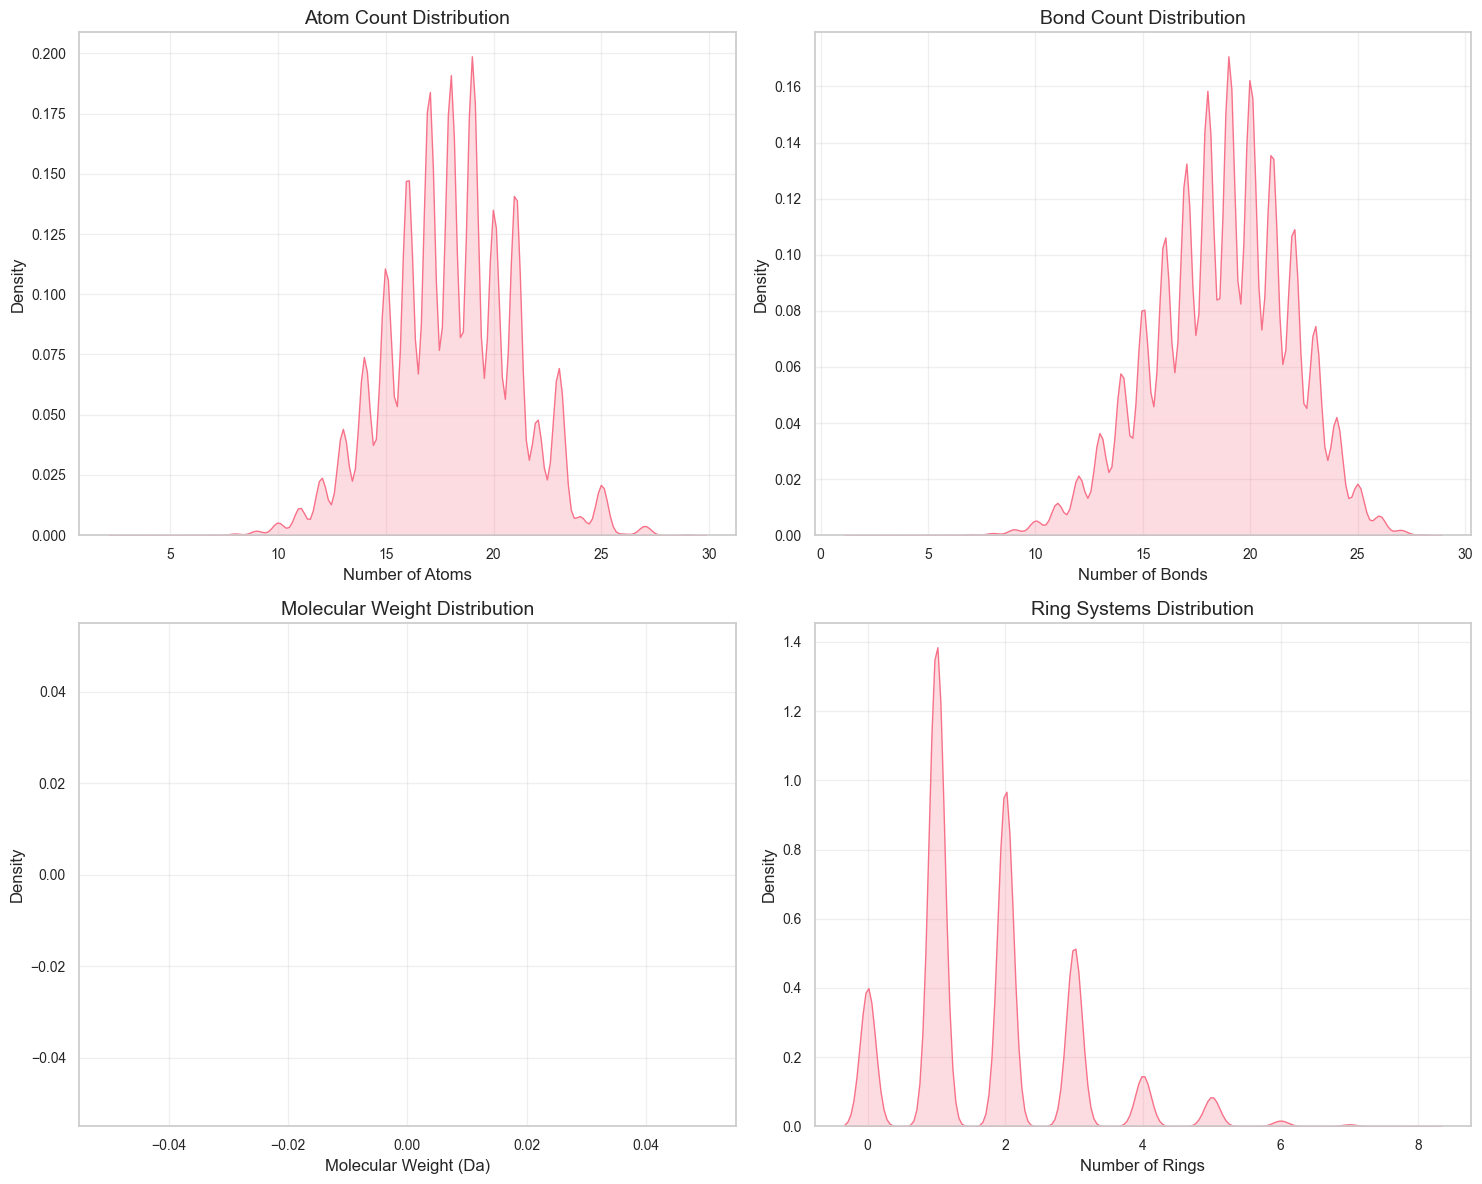

C:\Users\friha\AppData\Local\Temp\ipykernel_7884\4111941563.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(lengths, label=f'Bond Type {bt}', fill=True)
C:\Users\friha\AppData\Local\Temp\ipykernel_7884\4111941563.py:172: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


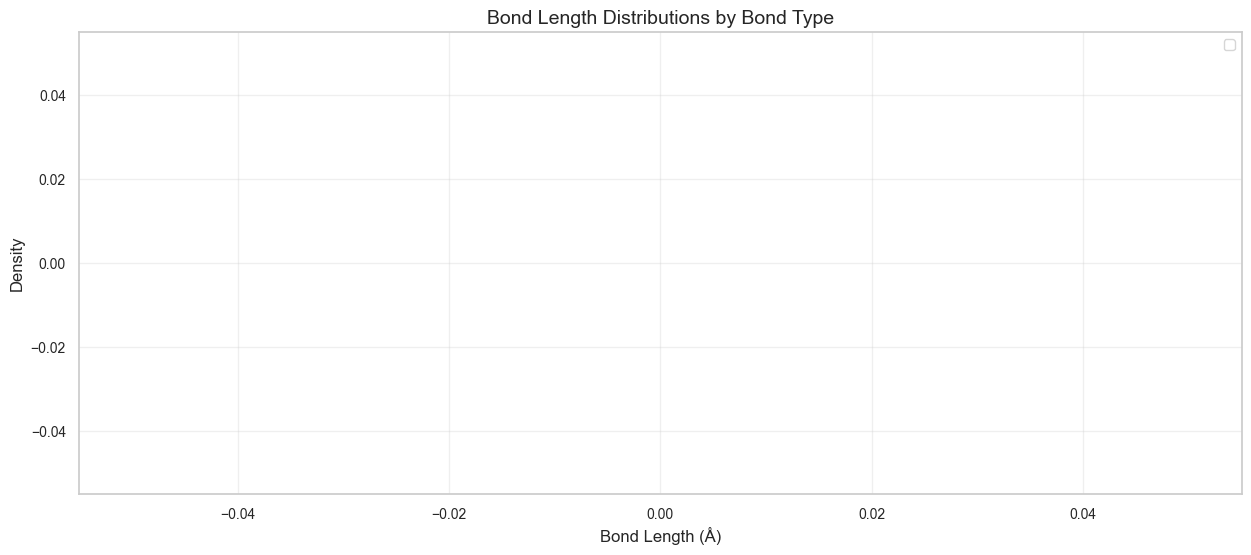

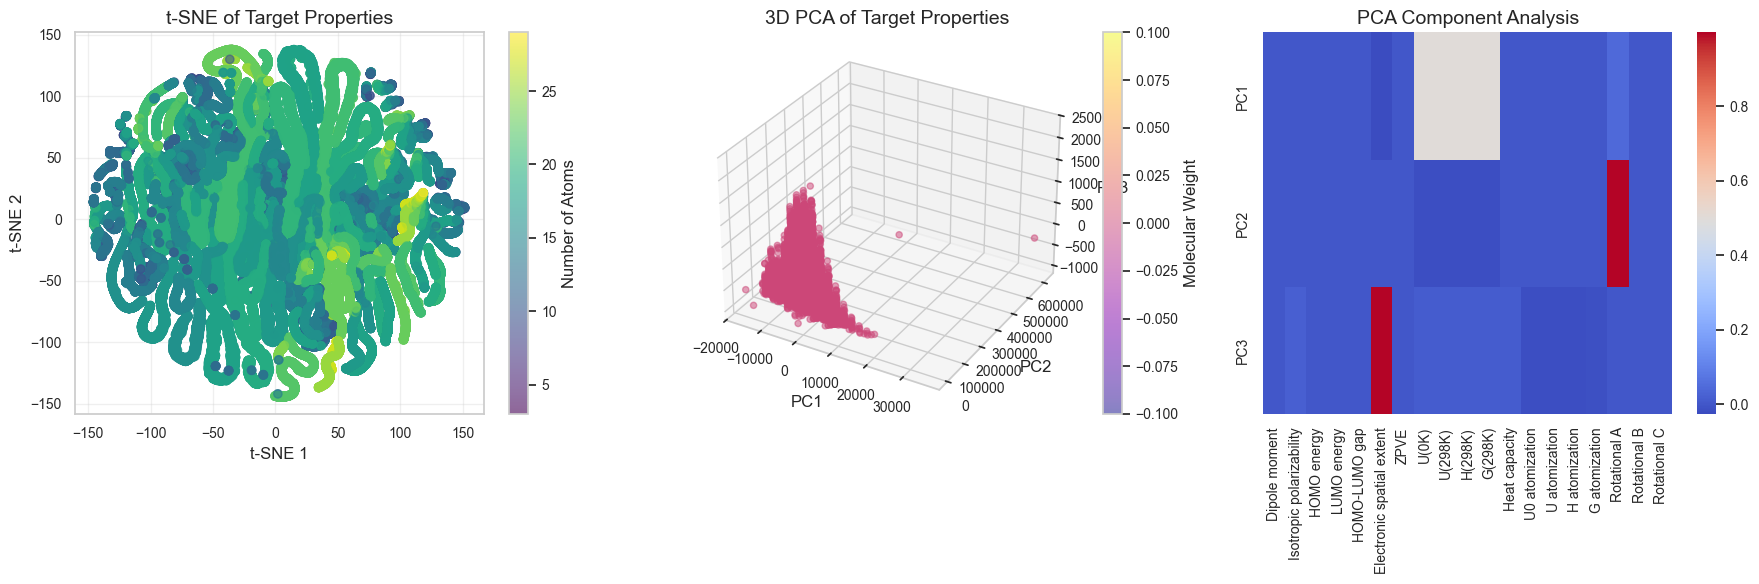

Graph Analysis:   1%|▏         | 14/1000 [00:08<11:38,  1.41it/s]c:\Users\friha\.conda\envs\NetSci\lib\site-packages\networkx\algorithms\smallworld.py:310: RuntimeWarning: invalid value encountered in scalar divide
  sigma = (C / Cr) / (L / Lr)
Graph Analysis:  14%|█▍        | 143/1000 [01:05<07:29,  1.91it/s]c:\Users\friha\.conda\envs\NetSci\lib\site-packages\networkx\algorithms\smallworld.py:310: RuntimeWarning: divide by zero encountered in scalar divide
  sigma = (C / Cr) / (L / Lr)
Graph Analysis: 100%|██████████| 1000/1000 [07:04<00:00,  2.36it/s]


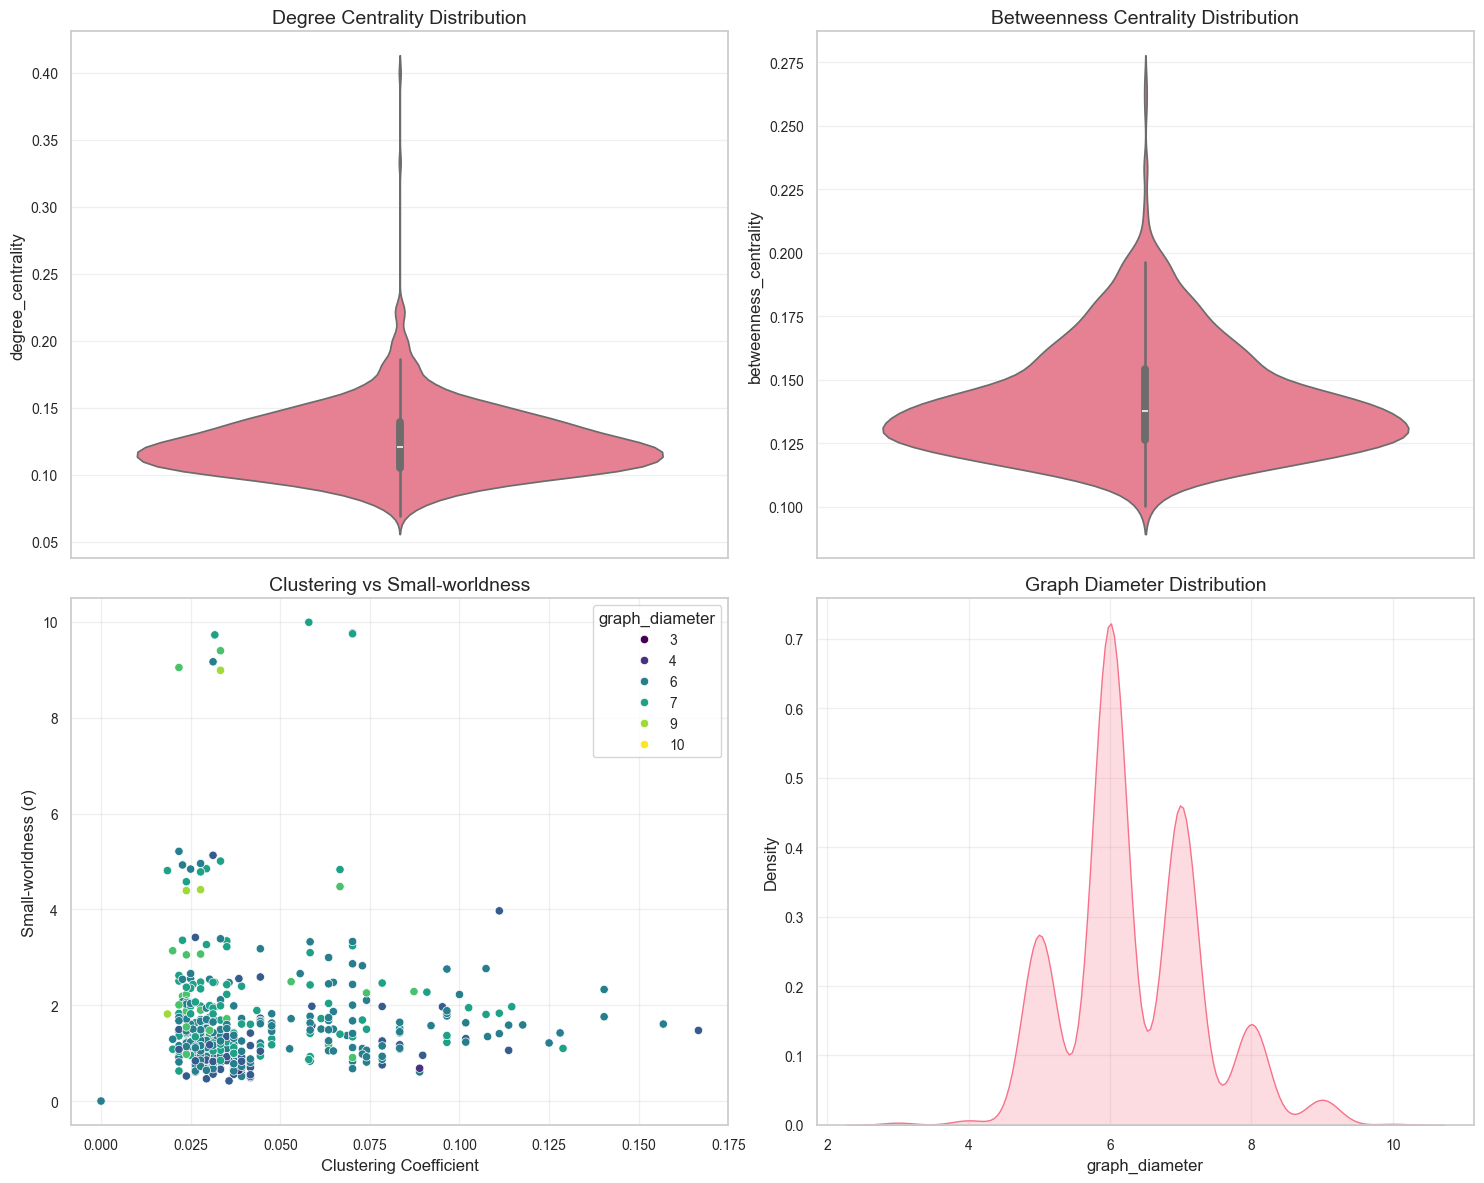

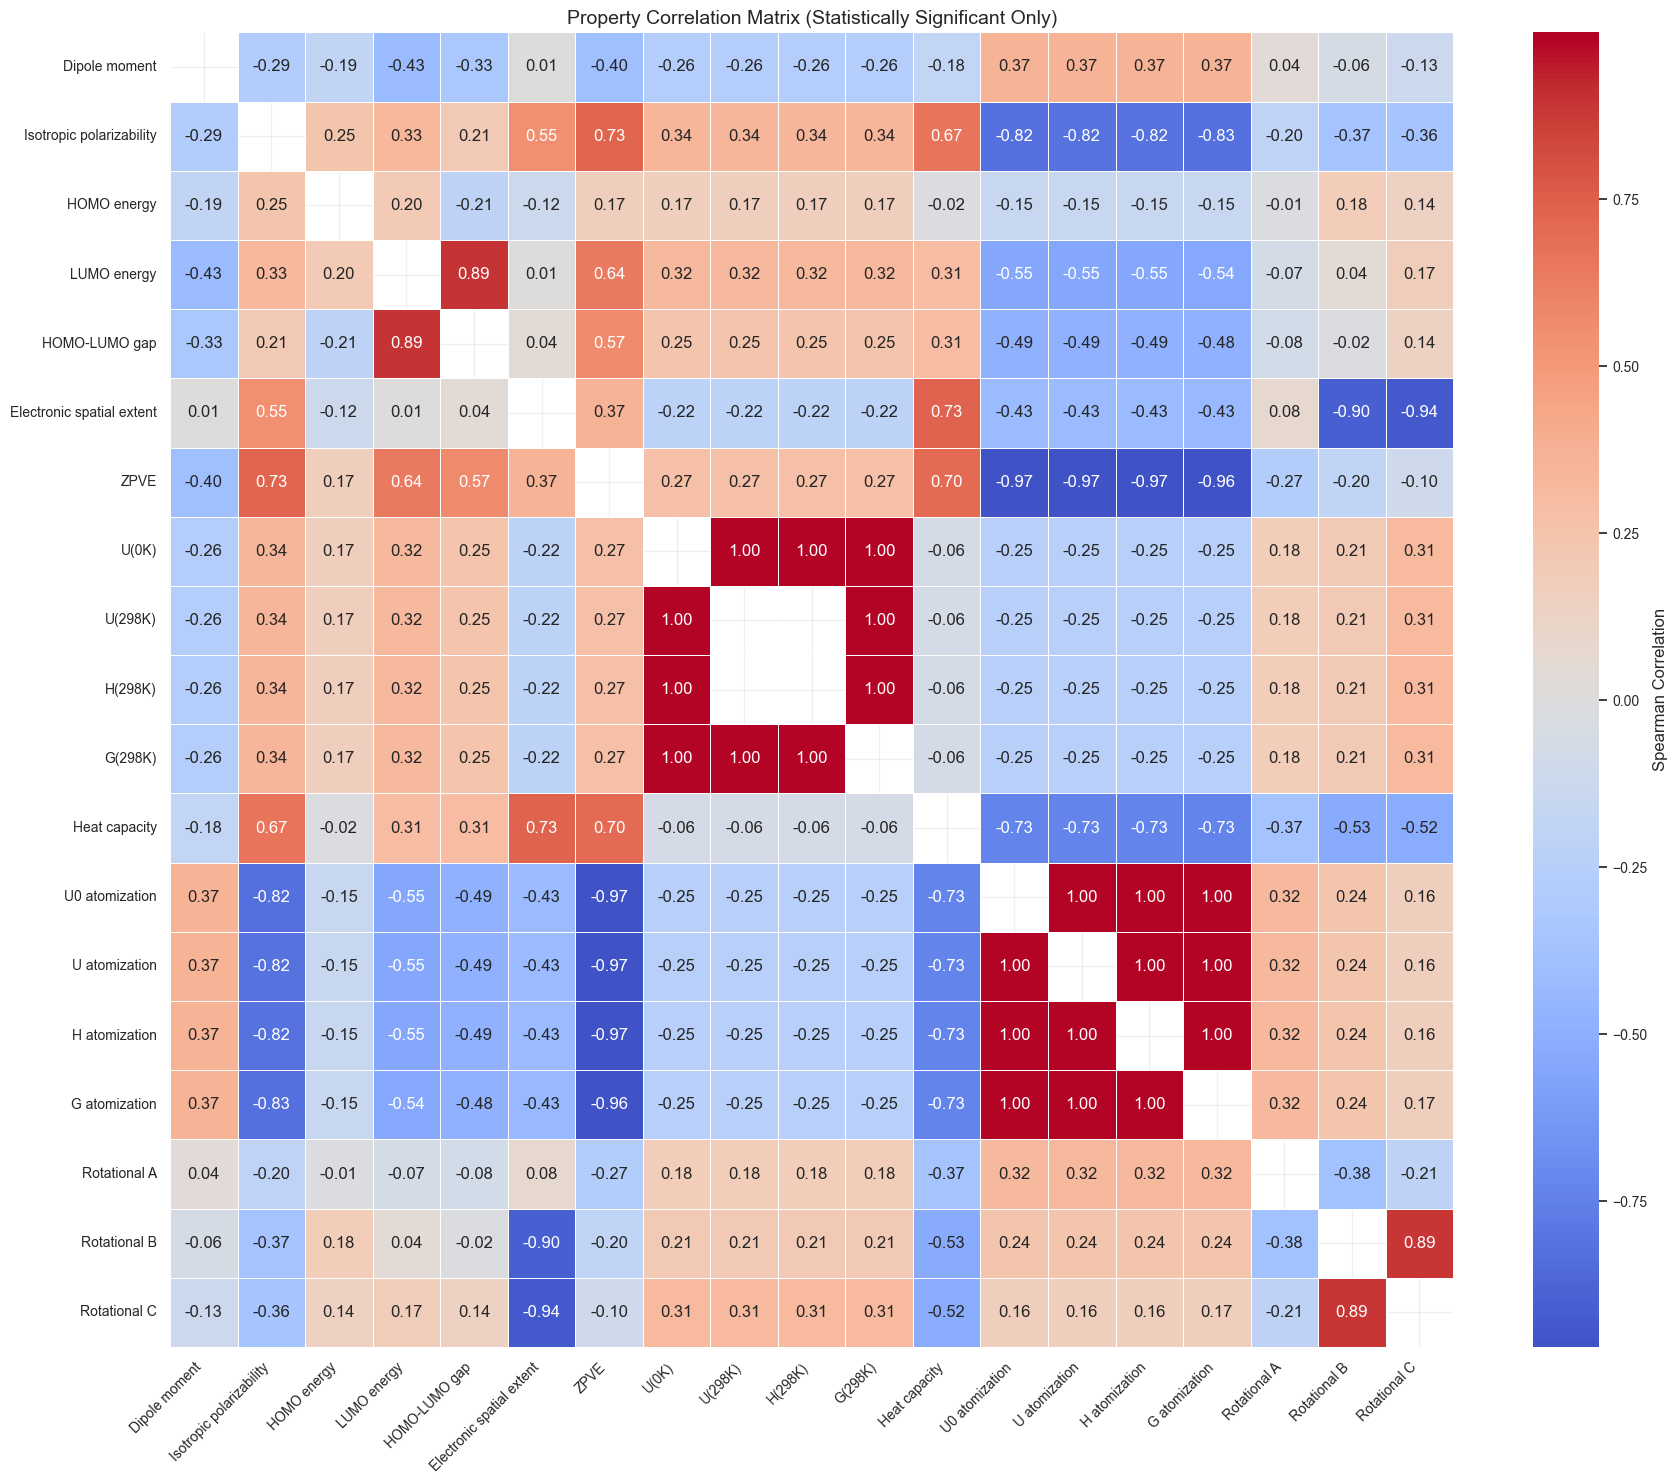

Scaffold Analysis: 100%|██████████| 1000/1000 [00:00<00:00, 1010.60it/s]
C:\Users\friha\AppData\Local\Temp\ipykernel_7884\4111941563.py:354: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scaffolds.values, y=top_scaffolds.index, palette='viridis')


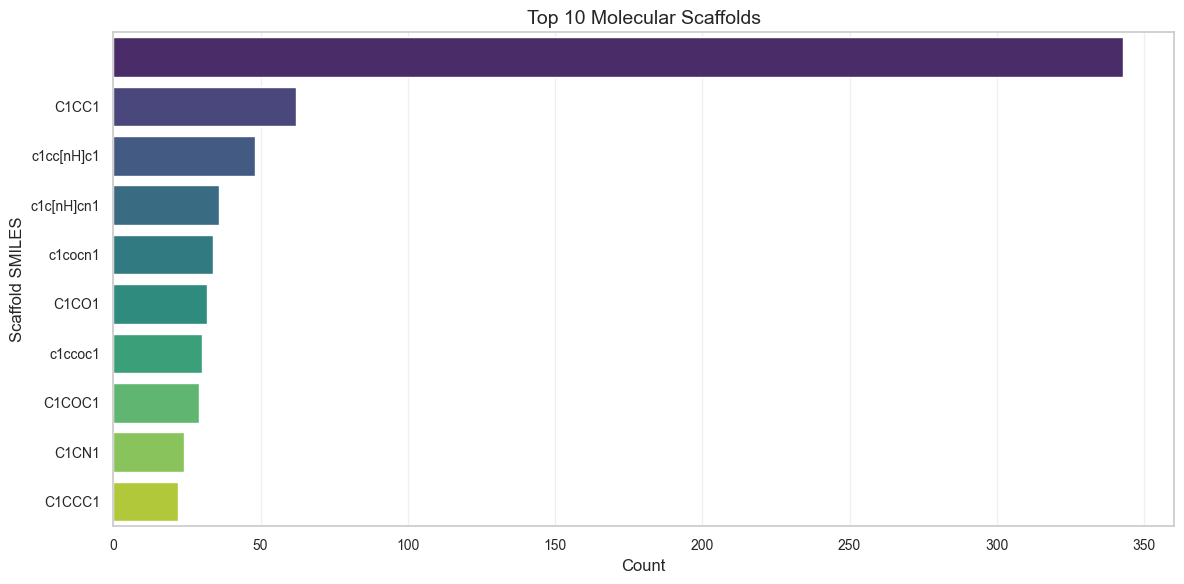

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import py3Dmol
import networkx as nx
from scipy.stats import gaussian_kde, kstest
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

# Initialize settings
# Initialize settings - CORRECTED
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'figure.dpi': 100,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'lines.linewidth': 1.5,
    'axes.grid': True,
    'grid.alpha': 0.3
})
pd.set_option('display.precision', 3)
torch.manual_seed(42)

# Load full dataset
class QM9Analyzer(Dataset):
    def __init__(self, root):
        super(QM9Analyzer, self).__init__(root)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self):
        return []
    
    @property
    def processed_file_names(self):
        return ['qm9.pt']
    
    def download(self):
        pass
    
    def process(self):
        pass

#dataset = QM9Analyzer(root='DATA/QM9')
dataset = QM9(root=DATA)

# %% [markdown]
# ## 1. Basic Dataset Statistics
# Compute fundamental statistics about the dataset composition

# %%
# Molecular statistics
mol_stats = {
    'num_atoms': [],
    'num_bonds': [],
    'atom_composition': [],
    'mol_weight': [],
    'ring_systems': []
}

# Atomic statistics
atom_counter = np.zeros(5)  # H, C, N, O, F

# Bond analysis with validation and error handling
from collections import defaultdict
bond_lengths = defaultdict(list)
valid_bond_types = {1.0, 1.5, 2.0, 3.0}
unexpected_bonds = set()

# Progress bar for dataset iteration
pbar = tqdm(total=len(dataset), desc='Analyzing molecules')
for data in dataset:
    # Molecular properties
    num_atoms = data.num_nodes
    num_bonds = data.edge_index.shape[1] // 2  # Undirected graph
    mol_stats['num_atoms'].append(num_atoms)
    mol_stats['num_bonds'].append(num_bonds)
    
    # Atom composition
    atom_types = torch.argmax(data.x[:, :5], dim=1).numpy()
    unique, counts = np.unique(atom_types, return_counts=True)
    mol_stats['atom_composition'].append(dict(zip(unique, counts)))
    
    # Bond analysis with type validation
    bond_type = data.edge_attr[:, 0].numpy()
    bond_length = data.edge_attr[:, 1].numpy()
    
    for bt, bl in zip(bond_type, bond_length):
        rounded_bt = round(bt.item(), 1)
        
        # Validate bond type before storing
        if rounded_bt not in valid_bond_types:
            unexpected_bonds.add(rounded_bt)
            continue  # Skip invalid bonds
            
        bond_lengths[rounded_bt].append(bl)
    
    # Molecular weight calculation
    weights = data.x[:, 7].numpy()  # Atomic mass feature
    mol_stats['mol_weight'].append(weights.sum())
    
    # Ring systems analysis
    mol = Chem.MolFromSmiles(data.smiles)
    if mol:
        ri = mol.GetRingInfo()
        mol_stats['ring_systems'].append(ri.NumRings())
    else:
        mol_stats['ring_systems'].append(0)
    
    pbar.update(1)
pbar.close()

# Post-processing validation
if unexpected_bonds:
    print(f"\nData Quality Warning: Found {len(unexpected_bonds)} unexpected bond types:")
    for bt in unexpected_bonds:
        print(f" - Bond type {bt}")
    print("These bonds have been excluded from analysis.")

# Convert to regular dict for plotting
bond_lengths = {k: v for k, v in bond_lengths.items() if k in valid_bond_types}

# Convert to DataFrame
mol_df = pd.DataFrame(mol_stats)

# %% [markdown]
# ## 2. Advanced Distribution Analysis
# Statistical analysis of key molecular properties

# %%
# Molecular size distributions
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
sns.kdeplot(mol_df['num_atoms'], ax=ax[0,0], fill=True)
ax[0,0].set_title('Atom Count Distribution')
ax[0,0].set_xlabel('Number of Atoms')

sns.kdeplot(mol_df['num_bonds'], ax=ax[0,1], fill=True)
ax[0,1].set_title('Bond Count Distribution')
ax[0,1].set_xlabel('Number of Bonds')

sns.kdeplot(mol_df['mol_weight'], ax=ax[1,0], fill=True)
ax[1,0].set_title('Molecular Weight Distribution')
ax[1,0].set_xlabel('Molecular Weight (Da)')

sns.kdeplot(mol_df['ring_systems'], ax=ax[1,1], fill=True)
ax[1,1].set_title('Ring Systems Distribution')
ax[1,1].set_xlabel('Number of Rings')

plt.tight_layout()
plt.show()

# Bond length analysis
fig = plt.figure(figsize=(15, 6))
for i, (bt, lengths) in enumerate(bond_lengths.items()):
    sns.kdeplot(lengths, label=f'Bond Type {bt}', fill=True)
plt.title('Bond Length Distributions by Bond Type')
plt.xlabel('Bond Length (Å)')
plt.legend()
plt.show()

# %% [markdown]
# ## 3. Chemical Space Visualization
# High-dimensional embedding of molecular properties

# %%
# Prepare target properties matrix
targets = torch.stack([data.y[0] for data in dataset]).numpy()

# t-SNE visualization
tsne = TSNE(n_components=2, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(targets)

# PCA visualization
pca = PCA(n_components=3)
pca_results = pca.fit_transform(targets)

# Plotting
fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131)
scatter = ax1.scatter(tsne_results[:,0], tsne_results[:,1], 
                     c=mol_df['num_atoms'], cmap='viridis', alpha=0.6)
ax1.set_title('t-SNE of Target Properties')
ax1.set_xlabel('t-SNE 1')
ax1.set_ylabel('t-SNE 2')
plt.colorbar(scatter, label='Number of Atoms')

ax2 = fig.add_subplot(132, projection='3d')
sc = ax2.scatter(pca_results[:,0], pca_results[:,1], pca_results[:,2],
                c=mol_df['mol_weight'], cmap='plasma', alpha=0.5)
ax2.set_title('3D PCA of Target Properties')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
plt.colorbar(sc, label='Molecular Weight')

ax3 = fig.add_subplot(133)
sns.heatmap(pca.components_, cmap='coolwarm',
           yticklabels=['PC1','PC2','PC3'],
           xticklabels=property_names)
ax3.set_title('PCA Component Analysis')
ax3.set_xticklabels(property_names, rotation=90)

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 4. Graph Theoretical Analysis
# Advanced analysis of graph structure properties

# %%
# Graph metrics calculation
graph_metrics = {
    'degree_centrality': [],
    'betweenness_centrality': [],
    'clustering_coeff': [],
    'graph_diameter': [],
    'small_worldness': []
}

sample_indices = np.random.choice(len(dataset), 1000, replace=False)
for idx in tqdm(sample_indices, desc='Graph Analysis'):
    data = dataset[idx]
    G = nx.Graph()
    G.add_nodes_from(range(data.num_nodes))
    edges = data.edge_index.t().numpy()
    G.add_edges_from(edges)
    
    # Degree centrality
    degree_cent = np.mean(list(nx.degree_centrality(G).values()))
    graph_metrics['degree_centrality'].append(degree_cent)
    
    # Betweenness centrality
    between_cent = np.mean(list(nx.betweenness_centrality(G).values()))
    graph_metrics['betweenness_centrality'].append(between_cent)
    
    # Clustering coefficient
    clust_coeff = nx.average_clustering(G)
    graph_metrics['clustering_coeff'].append(clust_coeff)
    
    # Graph diameter
    try:
        diam = nx.diameter(G)
    except:
        diam = np.nan
    graph_metrics['graph_diameter'].append(diam)
    
    # Small-worldness
    sigma = nx.sigma(G, niter=5)
    graph_metrics['small_worldness'].append(sigma)

graph_df = pd.DataFrame(graph_metrics)

# Plot graph metrics
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
sns.violinplot(y=graph_df['degree_centrality'], ax=ax[0,0])
ax[0,0].set_title('Degree Centrality Distribution')

sns.violinplot(y=graph_df['betweenness_centrality'], ax=ax[0,1])
ax[0,1].set_title('Betweenness Centrality Distribution')

sns.scatterplot(x=graph_df['clustering_coeff'], y=graph_df['small_worldness'],
               hue=graph_df['graph_diameter'], ax=ax[1,0], palette='viridis')
ax[1,0].set_title('Clustering vs Small-worldness')
ax[1,0].set_xlabel('Clustering Coefficient')
ax[1,0].set_ylabel('Small-worldness (σ)')

sns.kdeplot(graph_df['graph_diameter'], ax=ax[1,1], fill=True)
ax[1,1].set_title('Graph Diameter Distribution')

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 5. Quantum Chemical Property Correlations
# Advanced correlation analysis with statistical testing

# %%
# Correlation matrix with statistical significance
target_df = pd.DataFrame(targets, columns=property_names)
corr_matrix = target_df.corr(method='spearman')

# Mask for statistical significance
p_values = np.zeros_like(corr_matrix)
for i in range(len(property_names)):
    for j in range(len(property_names)):
        _, p_values[i,j] = kstest(target_df.iloc[:,i], target_df.iloc[:,j])

mask = p_values > 0.05  # Not statistically significant

# Plot correlation matrix
plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
           annot=True, fmt=".2f", linewidths=.5,
           cbar_kws={'label': 'Spearman Correlation'})
plt.title('Property Correlation Matrix (Statistically Significant Only)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 6. Molecular Scaffold Analysis
# Chemical pattern discovery using RDKit

# %%
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold

# Scaffold analysis
scaffold_stats = {
    'scaffold_class': [],
    'complexity': [],
    'num_rotatable_bonds': [],
    'num_aromatic_rings': []
}

for data in tqdm(dataset[:1000], desc='Scaffold Analysis'):  # Subsample for speed
    mol = Chem.MolFromSmiles(data.smiles)
    if mol:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        scaffold_stats['scaffold_class'].append(
            MurckoScaffold.MurckoScaffoldSmiles(mol=scaffold)
        )
        scaffold_stats['complexity'].append(
            Descriptors.MolWt(scaffold)/Descriptors.MolWt(mol)
        )
        scaffold_stats['num_rotatable_bonds'].append(
            Descriptors.NumRotatableBonds(mol)
        )
        scaffold_stats['num_aromatic_rings'].append(
            Descriptors.NumAromaticRings(mol)
        )

scaffold_df = pd.DataFrame(scaffold_stats)

# Scaffold diversity analysis
top_scaffolds = scaffold_df['scaffold_class'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_scaffolds.values, y=top_scaffolds.index, palette='viridis')
plt.title('Top 10 Molecular Scaffolds')
plt.xlabel('Count')
plt.ylabel('Scaffold SMILES')
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 7. 3D Geometry Analysis
# Spatial distribution of atomic coordinates

# %%
# 3D coordinate analysis
all_pos = torch.cat([data.pos for data in dataset]).numpy()

# Kernel Density Estimation
xyz = all_pos.T
kde = gaussian_kde(xyz)(xyz)

# 3D plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(xyz[0], xyz[1], xyz[2], c=kde, cmap='viridis', alpha=0.02)
ax.set_title('3D Atomic Coordinate Density')
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
plt.colorbar(sc, label='Density Estimate')
plt.show()

# %% [markdown]
# ## 8. Intermolecular Similarity Analysis
# Advanced similarity metrics using molecular fingerprints

# %%
from rdkit import DataStructs
from rdkit.Chem import AllChem

# Generate fingerprints
fps = []
for data in tqdm(dataset[:1000], desc='Fingerprinting'):  # Subsample
    mol = Chem.MolFromSmiles(data.smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        fps.append(fp)
    else:
        fps.append(None)

# Similarity matrix
similarity = np.zeros((len(fps), len(fps)))
for i in tqdm(range(len(fps)), desc='Calculating Similarities'):
    for j in range(i+1, len(fps)):
        if fps[i] and fps[j]:
            similarity[i,j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])
            
# Visualization
plt.figure(figsize=(12, 10))
sns.heatmap(similarity, cmap='YlGnBu', square=True, 
           xticklabels=False, yticklabels=False)
plt.title('Molecular Similarity Matrix (Tanimoto)')
plt.xlabel('Molecules')
plt.ylabel('Molecules')

plt.show()